In [12]:
import os
import cv2
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [17]:
image_path = r'D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg'
xml_path = r'D:\FracAtlas_extracted\FracAtlas\Annotations\PASCAL VOC\IMG0000777.xml'
print("Image Path:", image_path)
print("XML Path:", xml_path)

class_map = {"fracture": 1}

tree = ET.parse(xml_path)
root = tree.getroot()
xml_filename_node = root.find('filename')
if xml_filename_node is not None:
    xml_filename = xml_filename_node.text
    
objects =[]
for obj in root.findall("object"):
    label= obj.find("name").text
    bbox = obj.find('bndbox')
    
    #convert coordinates to int(strip float if any)
    xmin = int(float(bbox.find('xmin').text))
    ymin = int(float(bbox.find('ymin').text))
    xmax = int(float(bbox.find('xmax').text))
    ymax = int(float(bbox.find('ymax').text))
    
    objects.append((label, xmin, ymin, xmax, ymax))
    
print("Parsed Objects:", objects)



Image Path: D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg
XML Path: D:\FracAtlas_extracted\FracAtlas\Annotations\PASCAL VOC\IMG0000777.xml
Parsed Objects: [('fractured', 231, 37, 280, 98)]


In [18]:
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

height, width = image.shape[:2]
print("Image Shape:", image.shape)
print("Image Size:", width, "x", height)


Image Shape: (454, 373, 3)
Image Size: 373 x 454


In [20]:
mask = np.zeros((height, width), dtype=np.uint8)

for (label, xmin, ymin, xmax, ymax) in objects:
    class_id = class_map.get(label, None)
    if class_id is None:
        print(f"Skipping unknown label: {label}")
        continue

    xmin_clamped = max(0, min(xmin, width - 1))
    xmax_clamped = max(0, min(xmax, width - 1))
    ymin_clamped = max(0, min(ymin, height - 1))
    ymax_clamped = max(0, min(ymax, height - 1))

    if xmax_clamped <= xmin_clamped or ymax_clamped <= ymin_clamped:
        print(f"Warning: invalid bbox for {label}: ({xmin},{ymin}), ({xmax},{ymax}) (skipped)")
        continue

    mask[ymin_clamped:ymax_clamped, xmin_clamped:xmax_clamped] = class_id


Skipping unknown label: fractured


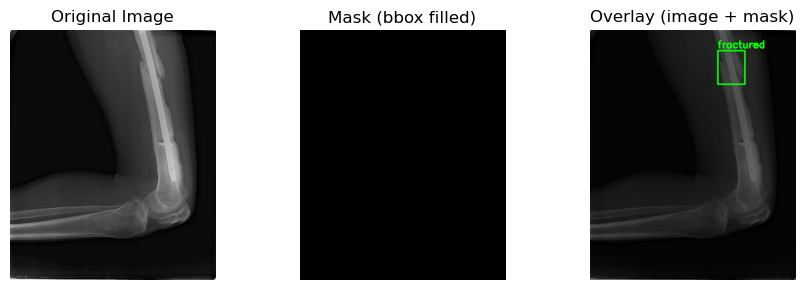

In [24]:
# 5) Prepare visualization (overlay) 
# # --------------------------- 
# # Create a colored mask (red color for fractured); scale class id -> color mapping as needed 
colored_mask = np.zeros_like(image) 
# Example: use red for class_id == 1 
colored_mask[mask == 1] = [255, 0, 0] 
# red overlay for fractured region 
# # Blend image and colored mask (alpha controls transparency) 
alpha = 0.5 
overlay = (image * (1 - alpha) + colored_mask * alpha).astype(np.uint8)

# --------------------------- 
# # 6) Display inline: original, mask, overlay
# # --------------------------- 


# Draw bounding boxes on overlay (for visualization)
for (label, xmin, ymin, xmax, ymax) in objects:
    color = (0, 255, 0)  # green boxes
    thickness = 2
    cv2.rectangle(overlay, (xmin, ymin), (xmax, ymax), color, thickness)
    cv2.putText(overlay, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image") 
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask (bbox filled)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay) 
plt.title("Overlay (image + mask)")
plt.axis("off") 
plt.tight_layout() 
plt.show()